# Projet MOGPL

#### Antonin ARBERET - 3407709
#### Madina TRAORÉ - 3412847

### Imporations

In [1]:
from gurobipy import *
import string
import re
from matplotlib import pyplot as plt
import numpy as np

### Chargement des fichiers en mémoire

In [79]:
#Lecture du fichier villes, retourne une liste de str contenant les noms des villes

def parse_villes(nom_fichier):
    villes=[]
    fichier = open(nom_fichier, "r")
    regex = re.compile(r'[\n\r\t]')
    for ligne in fichier:
        villes.append(regex.sub('', ligne))
    fichier.close()
    return villes

In [80]:
#Lecture du fichier populations, retourne une liste de int
#contenant les populations dans l'ordre alphabetique de leur villes respectives

def parse_populations(nom_fichier):
    pop=[]
    fichier = open(nom_fichier, "r")
    regex = re.compile(r'[\n\r\t]')
    for ligne in fichier:
        valeur=ligne.split(',')
        pop.append(int(regex.sub('', valeur[1])))
    fichier.close()
    return pop

In [81]:
#Lecture du fichier coordonées, retourne une liste de couple 
#contenant les deux coordonnées dans l'ordre alphabetique de leur villes respectives

def parse_coordonnees(nom_fichier):
    coord=[]
    fichier = open(nom_fichier, "r")
    regex = re.compile(r'[\n\r\t]')
    for ligne in fichier:
        valeur=ligne.split(',')
        coord.append((int((regex.sub('', valeur[1]))),int((regex.sub('', valeur[2])))))
    fichier.close()
    return coord

In [82]:
#Paramètres: fichier distance, nombre de villes, retourne une liste de liste 
#contenant les distance dans l'ordre alphabetique de leur villes respectives :
#dist[i][j] = distance de la i-ème à la j-ème ville dans la liste

def parse_distances(nom_fichier, nb_villes):
    dist=[]
    fichier = open(nom_fichier, "r")
    regex = re.compile(r'[\n\r\t]')
    cpt=0
    ind=-1
    for ligne in fichier:
        if(cpt%(nb_villes+1)==0):
            ind+=1
            dist.append([])
        else:
            valeur=ligne.split(',')
            dist[ind].append(float(regex.sub('', ligne)))
        cpt+=1
    fichier.close()
    return dist

In [83]:
villes=parse_villes("Data-20181122/villes92.txt")
pop=parse_populations("Data-20181122/populations92.txt")
coord=parse_coordonnees("Data-20181122/coordvilles92.txt")
dist=parse_distances("Data-20181122/distances92.txt", len(villes))
carte='Data-20181122/92.png'

### Fonctions d'affichage

In [84]:
#Fonction de gestion des couleurs pour les graphes

def get_color(k):
    colors=['b-','g-','r-','c-','m-','y-']
    return colors[k%len(colors)]

In [85]:
#Paramètres : image de la carte, matrice retourné par les fonction d'optimisations, liste des indices
#des ressources liste des coordonnées 
#Affiche la carte avec les relations villes ressources

def trace_reseau(fich_image, X, v_ressources, coord):
    img = plt.imread(fich_image)
    plt.imshow(img)
    
    for k in range(len(v_ressources)):
        coordk= coord[v_ressources[k]]
        c=get_color(k)
        plt.plot(coordk[0],coordk[1], c, marker='D')
    
    for i in range(len(X)):
        for j in range(len(X[i])):
            if(X[i][j]==1):
                c=get_color(j)
                (x1, y1)=coord[i]
                (x2, y2)=coord[v_ressources[j]]
                plt.plot([x1, x2], [y1, y2], c, lw=1)
    plt.show()

In [86]:
#Paramètres : image de la carte, matrice retourné par les fonction d'optimisations, liste des indices
#des ressources, liste des coordonnées, fichier pour l'enregistrement
#Affiche et enregistre dans dest la carte avec les relations villes ressources

def save_reseau(fich_image, X, v_ressources, coord,dest):
    img = plt.imread(fich_image)
    plt.imshow(img)
    
    for k in range(len(v_ressources)):
        coordk= coord[v_ressources[k]]
        c=get_color(k)
        plt.plot(coordk[0],coordk[1], c, marker='D')
    
    for i in range(len(X)):
        for j in range(len(X[i])):
            if(X[i][j]==1):
                c=get_color(j)
                (x1, y1)=coord[i]
                (x2, y2)=coord[v_ressources[j]]
                plt.plot([x1, x2], [y1, y2], c, lw=1)
    plt.savefig("%s.png"%(dest))

### Fonctions de manipulation diverses

In [87]:
#Paramètres : liste des populations
#retourne la population totale

def get_pop_tot(populations):
    tot=0
    for p in populations:
        tot+=p
    return tot

### Question 1

In [88]:
#Paramètres: nombre de ville, nombre de ressources, facteur alpha, liste des indices des villes
#contenant les ressources, matrice de distances. Retourne une matrice X telle que X[i][j]=1 
#si la ville d'indice i dépend de la ville contenant une ressources d'indice j dans v_ressources
#Retourne une matrice |I|*k contenant les x_ij

#k est redondant avec la taille de la liste v_ressources mais simplifie la lecture

def optimisation_Q1(nbvilles, k, alpha, v_ressources, dist):
    nbcont=nbvilles+k
    nbvar=nbvilles*k

    # Range of plants and warehouses

    lignes = range(nbcont)
    colonnes = range(nbvar)

    # Matrice des contraintes
    # Coefficients dans a, seconds membres dans b
    a=[]
    b=[]

    pop_tot= get_pop_tot(pop)

    # Ajout de i contraintes assurant qu'une ville n'est associées qu'a une seule ressource
    # Type (a)

    for i in range(nbvilles):
        ligne=[]

        for j in range(nbvilles*k):
            if(i*k<=j and (i+1)*k>j):
                ligne.append(1)
            else:
                ligne.append(0)
        b.append(1)
        a.append(ligne)

    # Ajout de j contraintes assurant que la population associé à un équipement ne dépasse pas la limite
    # Type (b)
    
    for j in range(k):
        ligne=[]
        for ij in range(nbvilles*k):
            if((ij-j)%k==0):
                i=np.floor(ij*1.0/k)
                ligne.append(pop[int(i)])
            else:
                ligne.append(0)
        a.append(ligne)
        b.append(pop_tot*(1+alpha)/k)


    # Coefficients de la fonction objectif
    # Ajout de i*j coefficient correspondant à la distance entre la ville et la ressource concernées

    c=[]
    for i in range(nbvilles):
        for j in v_ressources:
            c.append(dist[i][j])


    m = Model("mogplex")     

    # declaration variables de decision binaires
    x = []
    for i in colonnes:
        x.append(m.addVar(vtype=GRB.INTEGER, lb=0, name="x%d" % (i+1)))

    # maj du modele pour integrer les nouvelles variables
    m.update()

    obj = LinExpr();
    obj =0
    for j in colonnes:
        obj += c[j] * x[j]

    # definition de l'objectif
    m.setObjective(obj,GRB.MINIMIZE)

    # Definition des signes des contraintes
    for i in lignes:
        if i <nbvilles:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) >= b[i], "Contrainte%d" % i)
        else:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) <= b[i], "Contrainte%d" % i)


    # Resolution
    m.optimize()

    #Construction de la matrice
    X=[]
    ind=-1
    for j in colonnes:
        if(j%k==0):
            X.append([])
            ind=ind+1
        X[ind].append(x[j].x)
    return X

In [89]:
#Paramètres : Matrice renvoyée par une fonction d'optimisation, matrice des distances, liste des ressources
#Retourne un couple (satisfaction moy, satisfaction min)

def satisfaction(X, dist, v_ressources):
    dmax=0
    dmoy=0.
    for i in range(len(X)):
        for j in range(len(X[i])):
            if(X[i][j]==1):
                d=dist[i][v_ressources[j]]
                dmoy+=d
                if(d>dmax):
                    dmax=d
    dmoy=dmoy/len(X)
    return(1/dmoy,1/dmax)

### Question 2

In [90]:
#Paramètres: nombre de ville, nombre de ressources, facteur alpha, liste des indices des villes
#contenant les ressources, matrice des distances, facteur epsilon
#Retourne une matrice |I|*k contenant les x_ij

#Les nbvilles*k premières variables représentent la dépendance d'une ville vers une des k villes
#comportant une ressource.
#Les nbvilles*k suivante représentent la valeur max : la seule de ses variables à 1 est celle de la plus grande
#distance ville-ressource utilisée par le modèle actuellement
#
#Retourne une matrice X telle que X[i][j]=1 si la ville d'indice i
#dépend de la ville contenant une ressources d'indice j dans v_ressources
#k est redondant avec la taille de la liste v_ressources mais permet d'expliciter

def optimisation_Q2(nbvilles, k, alpha, v_ressources, dist, eps):
    nbcont=nbvilles+k+nbvilles*k+1
    nbvar=2*nbvilles*k

    # Range of plants and warehouses

    lignes = range(nbcont)
    colonnes = range(nbvar)

    # Matrice des contraintes
    # Coefficients dans a, seconds membres dans b
    a=[]
    b=[]

    pop_tot= get_pop_tot(pop)

    # Ajout de i contraintes assurant qu'une ville n'est associées qu'a une seule ressource
    # type (a)

    for i in range(nbvilles):
        ligne=[]

        for j in range(nbvilles*k):
            if(i*k<=j and (i+1)*k>j):
                ligne.append(1)
            else:
                ligne.append(0)
        for j in range(nbvilles*k):
            ligne.append(0)
        b.append(1)
        a.append(ligne)
        


    # Ajout de j contraintes assurant que la population associé à un équipement ne dépasse pas la limite
    #type (b)
    
    for j in range(k):
        ligne=[]
        for ij in range(nbvilles*k):
            if((ij-j)%k==0):
                i=np.floor(ij*1.0/k)
                ligne.append(pop[int(i)])
            else:
                ligne.append(0)
        for j in range(nbvilles*k):
            ligne.append(0)
        a.append(ligne)
        b.append(pop_tot*(1+alpha)/k)

    # Ajout de nbvilles*k contraintes assurant que la variable à 1 est bien celle de la distance maximale active
    # Type (c)
    
    for i in range(nbvilles*k):
        ligne=[]

        for j in range(nbvilles*k):
            if(j==i):
                ligne.append(-dist[int(math.floor(j/k))][v_ressources[j%k]])
            else:
                ligne.append(0)
        for j in range(nbvilles*k):
            ligne.append(dist[int(math.floor(j/k))][v_ressources[j%k]])
            
        b.append(0)
        a.append(ligne)
    
    # ajout d'une contrainte assurant que le total des variables représentant le max est 1
    # Type (d)
    ligne=[]

    for j in range(nbvilles*k):
        ligne.append(0)
    for j in range(nbvilles*k):
        ligne.append(1)

    b.append(1)
    a.append(ligne)
    
   


    # Coefficients de la fonction objectif
    # Ajout de i*j coefficient pondérés par epsilon correspondant à la distance entre la ville 
    # et la ressource concernées puis ajout de nbville*k coefficient pour les variables représentant
    # le maximum

    c=[]
    for i in range(nbvilles):
        for j in v_ressources:
            c.append(eps*dist[i][j])
    for j in range(nbvilles*k):
        c.append(dist[int(math.floor(j/k))][v_ressources[j%k]])


    m = Model("mogplex")     

    # declaration variables de decision binaires
    x = []
    for i in colonnes:
        x.append(m.addVar(vtype=GRB.BINARY, lb=0, name="x%d" % (i+1)))

    # maj du modele pour integrer les nouvelles variables
    m.update()

    obj = LinExpr();
    obj =0
    for j in colonnes:
        obj += c[j] * x[j]

    # definition de l'objectif
    m.setObjective(obj,GRB.MINIMIZE)

    # Definition des contraintes, on assure que la somme des variables de décision associée à une 
    # Definition des signes des contraintes
    for i in lignes:
        if i <nbvilles:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) >= b[i], "Contrainte%d" % i)
        elif i <nbvilles+k:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) <= b[i], "Contrainte%d" % i)
        elif i<nbvilles+k+nbvilles*k:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) >= b[i], "Contrainte%d" % i)
        else:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) == b[i], "Contrainte%d" % i)
            


    # Resolution
    m.optimize()


    #Construction de la matrice
    
    X=[]
    ind=-1
    for j in colonnes[:nbvilles*k]:
        if(j%k==0):
            X.append([])
            ind=ind+1
        X[ind].append(x[j].x)
    return X

In [91]:
#Prix de l'équité 
#Paramètres : Matrices Xf et Xg rendues par les fonctions d'optimisation sur une meme instance, liste 
#des resssources, matrice des distances
#Retourne le prix de l'équité

def PE(Xf, Xg, v_ressources, dist):
    dtotf=0.
    dtotg=0.
    for i in range(len(Xf)):
        for j in range(len(Xf[i])):
            if(Xf[i][j]==1):
                d=dist[i][v_ressources[j]]
                dtotf+=d
    for i in range(len(Xg)):
        for j in range(len(Xg[i])):
            if(Xg[i][j]==1):
                d=dist[i][v_ressources[j]]
                dtotg+=d
                
    pe=1-dtotf/dtotg
    return(pe)

### Question 3

In [92]:
#Paramètres: nombre de ville, nombre de ressources, facteur alpha, matrice des distances, facteur epsilon 
#Retourne une matrice X telle que X[i][j]=1 si la ville d'indice i


def optimisation_Q3(nbvilles, k, alpha, dist, eps):
    nbcont=2*nbvilles**2+2*nbvilles+2
    nbvar=2*nbvilles**2+nbvilles

    # Range of plants and warehouses

    lignes = range(nbcont)
    colonnes = range(nbvar)

    # Matrice des contraintes
    # Coefficients dans a, seconds membres dans b
    a=[]
    b=[]

    pop_tot= get_pop_tot(pop)

    # Ajout de i contraintes assurant qu'une ville n'est associées qu'a une seule ressource
    # type(a)

    for i in range(nbvilles):
        ligne=[]

        for j in range(nbvar):
            if(i*nbvilles<=j and (i+1)*nbvilles>j):
                ligne.append(1)
            else:
                ligne.append(0)
        b.append(1)
        a.append(ligne)
        
    # Ajout de i contraintes assurant que la ressource provient toujours d'une ville qui en est équipée
    # type (e)

    for i in range(nbvilles):
        for j in range(nbvilles):
            ligne=[]
            for n in range(nbvar):
                if(n==nbvilles*i+j):
                    ligne.append(1)
                elif(n==2*nbvilles**2+j):
                    ligne.append(-1)
                else:
                    ligne.append(0)
            b.append(0)
            a.append(ligne)
        


    # Ajout de j contraintes assurant que la population associé à un équipement ne dépasse pas la limite
    # type(b)

    for j in range(nbvilles):
        ligne=[]
        for ij in range(nbvar):
            if(ij<nbvilles**2):
                if((ij-j)%k==0):
                    i=np.floor(ij*1.0/nbvilles)
                    ligne.append(pop[int(i)])
                else:
                    ligne.append(0)
            else:
                ligne.append(0)
        a.append(ligne)
        b.append(pop_tot*(1+alpha)/k)

    # Ajout de nbvilles**2 contraintes assurant que la variable à 1 est bien celle de la distance maximale active
    # type(c)
    
    for i in range(nbvilles**2):
        ligne=[]
        for j in range(nbvar):
            if(j < nbvilles**2):
                if(j==i):
                    ligne.append(-dist[int(math.floor(j/nbvilles))][j%nbvilles])
                else:
                    ligne.append(0)
            elif(j < 2*nbvilles**2):
                ligne.append(dist[int(math.floor((j-nbvilles**2)/nbvilles))][(j-nbvilles)%nbvilles])
            else:
                ligne.append(0)
        b.append(0)
        a.append(ligne)
    
    #ajout de la contrainte assurant que le total des variables représentant le max est 1
    #type(d)
    
    ligne=[]
    
    for j in range(nbvar):
        if(j <nbvilles**2):
            ligne.append(0)
        elif(j<2*nbvilles**2):
            ligne.append(1)
        else:
            ligne.append(0)

    b.append(1)
    a.append(ligne)
    

    #ajout de la contraintes assurant que le total des ville équipée est k
    #type (f)
    
    ligne=[]
    
    for j in range(nbvar):
        if(j>=nbvar-nbvilles):
            ligne.append(1)
        else:
            ligne.append(0)

    b.append(k)
    a.append(ligne)


    # Coefficients de la fonction objectif
    # Ajout de i*j coefficient pondérés par epsilon correspondant à la distance entre la ville 
    # et la ressource concernées puis ajout de nbville*k coefficient pour les variables représentant
    # le maximum

    c=[]
               

    for i in range(nbvilles):
        for j in range(nbvilles):
            c.append(eps*dist[i][j])
    for j in range(nbvilles**2):
        c.append(dist[int(math.floor(j/nbvilles))][j%nbvilles])
    for j in range(nbvilles):
        c.append(0)


    m = Model("mogplex")     

    # declaration variables de decision entière pour n'avoir que des 1 et des 0
    x = []
    for i in colonnes:
        x.append(m.addVar(vtype=GRB.BINARY, lb=0, name="x%d" % (i+1)))

    # maj du modele pour integrer les nouvelles variables
    m.update()

    obj = LinExpr();
    obj =0
    for j in colonnes:
        obj += c[j] * x[j]

    # definition de l'objectif
    m.setObjective(obj,GRB.MINIMIZE)

    # Definition des signes des contraintes
    for i in lignes:
        if i <nbvilles:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) == b[i], "Contrainte%d" % i)
        elif i <nbvilles+nbvilles**2:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) <= b[i], "Contrainte%d" % i)
        elif i<2*nbvilles+nbvilles**2:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) <= b[i], "Contrainte%d" % i)
        elif i<2*nbvilles+2*nbvilles**2:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) >= b[i], "Contrainte%d" % i)
        elif i<2*nbvilles+2*nbvilles**2+1:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) == b[i], "Contrainte%d" % i)
        else:
            m.addConstr(quicksum(a[i][j]*x[j] for j in colonnes) == b[i], "Contrainte%d" % i)
            

    # Resolution
    m.optimize()
    
    ress=[]
    for j in range(nbvilles):
        if(x[2*nbvilles**2+j].x==1):
            ress.append(j)
    
    X=[]
    for i in range(nbvilles):
        X.append([])
        for j in range(nbvilles):
            if j in ress:
                X[i].append(x[i*nbvilles+j].x)
    

    return (X,ress)

### Tests

#### Comparaison des modèles des questions 1 et 2

#### Instance #1 - k=3, Villes : Courbevoie, Garches, Nanterre

##### alpha=0.1

##### Modèle question 1

Optimize a model with 39 rows, 108 columns and 216 nonzeros
Variable types: 0 continuous, 108 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 401.5700000
Presolve time: 0.00s
Presolved: 39 rows, 108 columns, 216 nonzeros
Variable types: 0 continuous, 108 integer (108 binary)

Root relaxation: objective 2.907820e+02, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  290.78202    0    4  401.57000  290.78202  27.6%     -    0s
H    0     0                     297.1200000  290.78202  2.13%     -    0s
H    0     0                     292.2000000  290.78202  0.49%     -    0s
     0     0     cutoff    0       292.20000  292.20000  0.00%     -    0s

Cutting planes:
  Cover: 1
  MIR: 

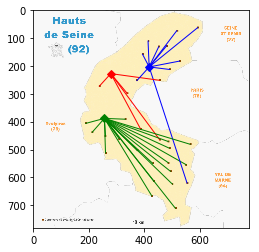

Satisfaction moyenne : 0.12320328542094458 et satifaction minimum :0.04868549172346641. 


In [93]:
#k = 3 alpha = 0.1, villes = Courbevoie, Garches, Nanterre

nbvilles=len(villes)
k=3
alpha=0.1
v_ressources=[12,14,24]

X_q1=optimisation_Q1(nbvilles, k, alpha, v_ressources, dist)

trace_reseau(carte, X_q1, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q1, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

##### Modèle question 2

Optimize a model with 148 rows, 216 columns and 11769 nonzeros
Variable types: 0 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e-06, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Presolve removed 49 rows and 99 columns
Presolve time: 0.03s
Presolved: 99 rows, 117 columns, 779 nonzeros
Variable types: 0 continuous, 117 integer (117 binary)
Found heuristic solution: objective 23.1603130
Found heuristic solution: objective 20.7403661

Root relaxation: objective 2.054034e+01, 36 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   20.54034    0    4   20.74037   20.54034  0.96%     -    0s
H    0     0                      20.5403182   20.54032  0.00%     -    0s

Explored 1 nodes (36 simplex iterations) in 0.07 seconds
Thread count was 4 (of 4 available p

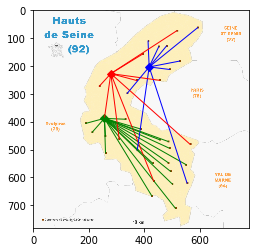

Satisfaction moyenne : 0.11312217194570136 et satifaction minimum :0.04868549172346641. 


In [94]:
#k = 3 alpha = 0.1, villes = Courbevoie, Garches, Nanterre

nbvilles=len(villes)
k=3
alpha=0.1
v_ressources=[12,14,24]
eps=10**(-6)

X_q2=optimisation_Q2(nbvilles, k, alpha, v_ressources, dist, eps)

trace_reseau(carte, X_q2, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q2, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

##### Prix de l'équité

In [95]:
print("Prix de l'équité : %f"%(PE(X_q1, X_q2, v_ressources, dist)))

Prix de l'équité : 0.081825


##### alpha=0.2

##### Modèle question 1

Optimize a model with 39 rows, 108 columns and 216 nonzeros
Variable types: 0 continuous, 108 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 394.0200000
Presolve time: 0.00s
Presolved: 39 rows, 108 columns, 216 nonzeros
Variable types: 0 continuous, 108 integer (108 binary)

Root relaxation: objective 2.866909e+02, 38 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  286.69087    0    2  394.02000  286.69087  27.2%     -    0s
H    0     0                     288.9800000  286.69087  0.79%     -    0s
*    0     0               0     288.9000000  288.90000  0.00%     -    0s

Cutting planes:
  Cover: 1

Explored 1 nodes (45 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4

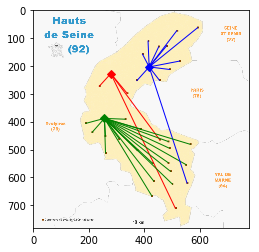

Satisfaction moyenne : 0.12461059190031155 et satifaction minimum :0.04317789291882556. 


In [96]:
#k = 3 alpha = 0.2, villes = Courbevoie, Garches, Nanterre

nbvilles=len(villes)
k=3
alpha=0.2
v_ressources=[12,14,24]

X_q1=optimisation_Q1(nbvilles, k, alpha, v_ressources, dist)

trace_reseau(carte, X_q1, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q1, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

##### Modèle question 2

Optimize a model with 148 rows, 216 columns and 11769 nonzeros
Variable types: 0 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e-06, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 23.2403099
Presolve removed 51 rows and 102 columns
Presolve time: 0.04s
Presolved: 97 rows, 114 columns, 714 nonzeros
Variable types: 0 continuous, 114 integer (114 binary)

Root relaxation: objective 2.054034e+01, 41 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   20.54034    0    4   23.24031   20.54034  11.6%     -    0s
H    0     0                      20.5403027   20.54030  0.00%     -    0s

Explored 1 nodes (41 simplex iterations) in 0.07 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 20.5403 23.2403 

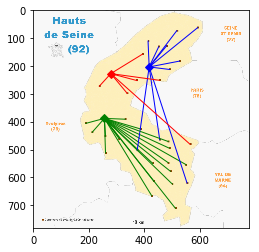

Satisfaction moyenne : 0.11891784758695868 et satifaction minimum :0.04868549172346641. 


In [97]:
#k = 3 alpha = 0.2, villes = Courbevoie, Garches, Nanterre

nbvilles=len(villes)
k=3
alpha=0.2
v_ressources=[12,14,24]
eps=10**(-6)

X_q2=optimisation_Q2(nbvilles, k, alpha, v_ressources, dist, eps)

trace_reseau(carte, X_q2, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q2, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

##### Prix de l'équité

In [98]:
print("Prix de l'équité : %f"%(PE(X_q1, X_q2, v_ressources, dist)))

Prix de l'équité : 0.045684


#### Instance #2 - k=4, Villes : Courbevoie, Garches, Le Plessis-Robinson, Nanterre

##### alpha = 0.1

##### Méthode question 1

Optimize a model with 40 rows, 144 columns and 288 nonzeros
Variable types: 0 continuous, 144 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+05]
Found heuristic solution: objective 393.8100000
Presolve time: 0.00s
Presolved: 40 rows, 144 columns, 288 nonzeros
Variable types: 0 continuous, 144 integer (144 binary)

Root relaxation: objective 1.611124e+02, 38 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  161.11239    0    4  393.81000  161.11239  59.1%     -    0s
H    0     0                     163.0100000  161.11239  1.16%     -    0s
     0     0     cutoff    0       163.01000  163.01000  0.00%     -    0s

Cutting planes:
  Cover: 1

Explored 1 nodes (40 simplex iterations) in 0.02 seconds
Thread count was 4 (of 4

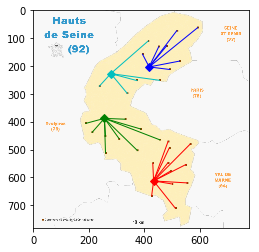

Satisfaction moyenne : 0.22084534691123245 et satifaction minimum :0.10319917440660475. 


In [99]:
#k = 4 alpha = 0.1, villes = Courbevoie, Garches, Le Plessis-Robinson, Nanterre

nbvilles=len(villes)
k=4
alpha=0.1
v_ressources=[12,14,18,24]

X_q1=optimisation_Q1(nbvilles, k, alpha, v_ressources, dist)

trace_reseau(carte, X_q1, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q1, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

##### Méthode question 2

Optimize a model with 185 rows, 288 columns and 20732 nonzeros
Variable types: 0 continuous, 288 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e-06, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+05]
Found heuristic solution: objective 18.5102998
Presolve removed 89 rows and 113 columns
Presolve time: 0.06s
Presolved: 96 rows, 175 columns, 2000 nonzeros
Variable types: 0 continuous, 175 integer (175 binary)

Root relaxation: objective 9.690175e+00, 68 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    9.69018    0    4   18.51030    9.69018  47.6%     -    0s
H    0     0                      18.5101697    9.69018  47.6%     -    0s
H    0     0                       9.6901668    9.69017  0.00%     -    0s

Explored 1 nodes (68 simplex iterations) in 0.10 seconds
Thread

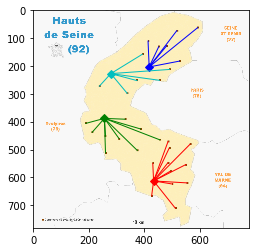

Satisfaction moyenne : 0.2157626610728199 et satifaction minimum :0.10319917440660475. 


In [100]:
#k = 4 alpha = 0.1, villes = Courbevoie, Garches, Le Plessis-Robinson, Nanterre

nbvilles=len(villes)
k=4
alpha=0.1
v_ressources=[12,14,18,24]
eps=10**(-6)

X_q2=optimisation_Q2(nbvilles, k, alpha, v_ressources, dist, eps)

trace_reseau(carte, X_q2, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q2, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

##### Prix de l'équité

In [101]:
print("Prix de l'équité : %f"%(PE(X_q1, X_q2, v_ressources, dist)))

Prix de l'équité : 0.023015


##### alpha = 0.2

Optimize a model with 40 rows, 144 columns and 288 nonzeros
Variable types: 0 continuous, 144 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+05]
Found heuristic solution: objective 364.5700000
Presolve time: 0.00s
Presolved: 40 rows, 144 columns, 288 nonzeros
Variable types: 0 continuous, 144 integer (144 binary)

Root relaxation: objective 1.572082e+02, 38 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  157.20819    0    4  364.57000  157.20819  56.9%     -    0s
H    0     0                     163.7100000  157.20819  3.97%     -    0s
H    0     0                     160.7100000  157.20819  2.18%     -    0s
H    0     0                     158.7900000  157.20819  1.00%     -    0s
     0     0     cutoff    0       

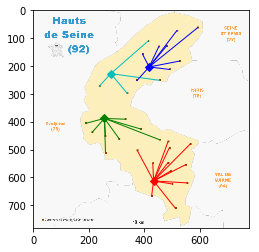

Satisfaction moyenne : 0.22671452862270927 et satifaction minimum :0.10319917440660475. 


In [102]:
#k = 4 alpha = 0.2, villes = Courbevoie, Garches, Le Plessis-Robinson, Nanterre

nbvilles=len(villes)
k=4
alpha=0.2
v_ressources=[12,14,18,24]

X_q1=optimisation_Q1(nbvilles, k, alpha, v_ressources, dist)

trace_reseau(carte, X_q1, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q1, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

Optimize a model with 185 rows, 288 columns and 20732 nonzeros
Variable types: 0 continuous, 288 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e-06, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Found heuristic solution: objective 18.5102995
Presolve removed 89 rows and 113 columns
Presolve time: 0.06s
Presolved: 96 rows, 175 columns, 2000 nonzeros
Variable types: 0 continuous, 175 integer (175 binary)

Root relaxation: objective 9.690170e+00, 48 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    9.69017    0    4   18.51030    9.69017  47.6%     -    0s
H    0     0                      11.5801635    9.69017  16.3%     -    0s
H    0     0                       9.6901684    9.69017  0.00%     -    0s

Explored 1 nodes (48 simplex iterations) in 0.09 seconds
Thread

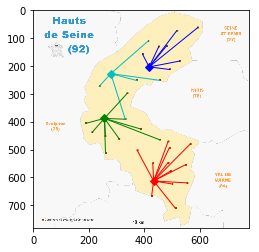

Satisfaction moyenne : 0.21382751247327159 et satifaction minimum :0.10319917440660475. 


In [103]:
#k = 4 alpha = 0.2, villes = Courbevoie, Garches, Le Plessis-Robinson, Nanterre

nbvilles=len(villes)
k=4
alpha=0.2
v_ressources=[12,14,18,24]
eps=10**(-6)

X_q2=optimisation_Q2(nbvilles, k, alpha, v_ressources, dist, eps)

trace_reseau(carte, X_q2, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q2, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

##### Prix de l'équité

In [104]:
print("Prix de l'équité : %f"%(PE(X_q1, X_q2, v_ressources, dist)))

Prix de l'équité : 0.056842


#### Instance #3 - k=5, Villes : Courbevoie, Garches, Le Plessis-Robinson, Nanterre, Sevres

##### alpha = 0.1

##### Méthode question 1

Optimize a model with 41 rows, 180 columns and 360 nonzeros
Variable types: 0 continuous, 180 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]
Found heuristic solution: objective 398.8400000
Presolve time: 0.00s
Presolved: 41 rows, 180 columns, 360 nonzeros
Variable types: 0 continuous, 180 integer (180 binary)

Root relaxation: objective 1.637919e+02, 48 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  163.79194    0    6  398.84000  163.79194  58.9%     -    0s
H    0     0                     166.4600000  163.79194  1.60%     -    0s
     0     0  166.00392    0    4  166.46000  166.00392  0.27%     -    0s
H    0     0                     166.3800000  166.00392  0.23%     -    0s
     0     0  166.01268    0    1  

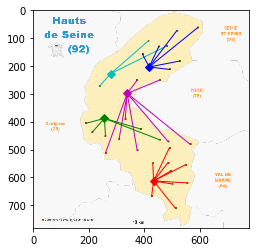

Satisfaction moyenne : 0.21646323131501413 et satifaction minimum :0.08658008658008658. 


In [105]:
#k = 5 alpha = 0.1, villes = Courbevoie, Garches, Le Plessis-Robinson, Nanterre, Sevres

nbvilles=len(villes)
k=5
alpha=0.1
v_ressources=[12,14,18,24,30]

X_q1=optimisation_Q1(nbvilles, k, alpha, v_ressources, dist)

trace_reseau(carte, X_q1, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q1, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

##### Méthode question 2

Optimize a model with 222 rows, 360 columns and 32215 nonzeros
Variable types: 0 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e-06, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]
Found heuristic solution: objective 17.7802017
Presolve removed 132 rows and 167 columns
Presolve time: 0.12s
Presolved: 90 rows, 193 columns, 1567 nonzeros
Variable types: 0 continuous, 193 integer (193 binary)

Root relaxation: objective 1.118019e+01, 84 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.18019    0    8   17.78020   11.18019  37.1%     -    0s
H    0     0                      11.1801762   11.18018  0.00%     -    0s

Explored 1 nodes (84 simplex iterations) in 0.15 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 11.1802 17.780

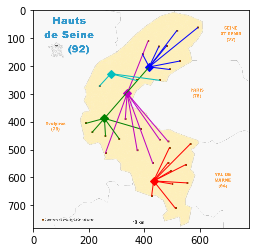

Satisfaction moyenne : 0.2043132803632236 et satifaction minimum :0.08944543828264759. 


In [106]:
#k = 5 alpha = 0.1, villes = Courbevoie, Garches, Le Plessis-Robinson, Nanterre, Sevres

nbvilles=len(villes)
k=5
alpha=0.1
v_ressources=[12,14,18,24,30]
eps=10**(-6)

X_q2=optimisation_Q2(nbvilles, k, alpha, v_ressources, dist, eps)

trace_reseau(carte, X_q2, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q2, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

##### Prix de l'équité

In [107]:
print("Prix de l'équité : %f"%(PE(X_q1, X_q2, v_ressources, dist)))

Prix de l'équité : 0.056129


##### alpha = 0.2

##### Méthode question 1

Optimize a model with 41 rows, 180 columns and 360 nonzeros
Variable types: 0 continuous, 180 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+05]
Found heuristic solution: objective 426.0800000
Presolve time: 0.00s
Presolved: 41 rows, 180 columns, 360 nonzeros
Variable types: 0 continuous, 180 integer (180 binary)

Root relaxation: objective 1.582697e+02, 44 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  158.26969    0    5  426.08000  158.26969  62.9%     -    0s
H    0     0                     163.2500000  158.26969  3.05%     -    0s
H    0     0                     162.4400000  158.26969  2.57%     -    0s
     0     0  159.79547    0   12  162.44000  159.79547  1.63%     -    0s
     0     0  159.79547    0    3  

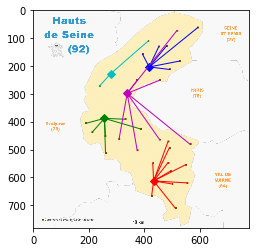

Satisfaction moyenne : 0.2233666315071043 et satifaction minimum :0.08658008658008658. 


In [108]:
#k = 5 alpha = 0.2, villes = Courbevoie, Garches, Le Plessis-Robinson, Nanterre, Sevres

nbvilles=len(villes)
k=5
alpha=0.2
v_ressources=[12,14,18,24,30]

X_q1=optimisation_Q1(nbvilles, k, alpha, v_ressources, dist)

trace_reseau(carte, X_q1, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q1, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

##### Méthode question 2

Optimize a model with 222 rows, 360 columns and 32215 nonzeros
Variable types: 0 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e-06, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+05]
Found heuristic solution: objective 21.3002162
Presolve removed 96 rows and 106 columns
Presolve time: 0.12s
Presolved: 126 rows, 254 columns, 4170 nonzeros
Variable types: 0 continuous, 254 integer (254 binary)

Root relaxation: objective 1.024017e+01, 102 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   10.24017    0    6   21.30022   10.24017  51.9%     -    0s
H    0     0                      19.4001788   10.24017  47.2%     -    0s
H    0     0                      10.2401705   10.24017  0.00%     -    0s

Explored 1 nodes (102 simplex iterations) in 0.15 seconds
Thr

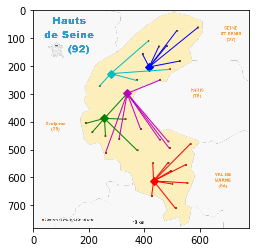

Satisfaction moyenne : 0.21113131194651338 et satifaction minimum :0.09765625. 


In [109]:
#k = 5 alpha = 0.1, villes = Courbevoie, Garches, Le Plessis-Robinson, Nanterre, Sevres

nbvilles=len(villes)
k=5
alpha=0.2
v_ressources=[12,14,18,24,30]
eps=10**(-6)

X_q2=optimisation_Q2(nbvilles, k, alpha, v_ressources, dist, eps)

trace_reseau(carte, X_q2, v_ressources, coord)

(satmoy, satmin)=satisfaction(X_q2, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

##### Prix de l'équité

In [110]:
print("Prix de l'équité : %f"%(PE(X_q1, X_q2, v_ressources, dist)))

Prix de l'équité : 0.054777


##### Recherche des villes optimales avec k donné

Optimize a model with 2666 rows, 2628 columns and 1654992 nonzeros
Variable types: 0 continuous, 2628 integer (2628 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+05]
  Objective range  [9e-07, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Presolve removed 69 rows and 322 columns
Presolve time: 4.52s
Presolved: 2597 rows, 2306 columns, 1231778 nonzeros
Variable types: 0 continuous, 2306 integer (2306 binary)
Found heuristic solution: objective 24.3403647

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.030700e+04   0.000000e+00      6s
    2096    2.5015192e-01   0.000000e+00   0.000000e+00      7s

Root relaxation: objective 2.501519e-01, 2096 iterations, 1.20 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.92046    0  629   24.34036    0.92046  96

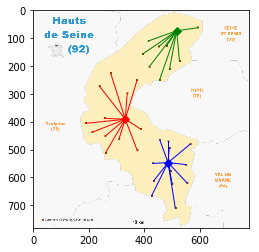

Villes ressources optimales:
Chatillon
Gennevilliers
Saint-Cloud
Satisfaction moyenne : 0.25688597117168543 et satifaction minimum :0.13986013986013984. 


In [111]:
#k = 3 

nbvilles=len(villes)
k=3
eps=10**(-6)
(X,v_ressources)=optimisation_Q3(nbvilles, k, alpha, dist, eps)
trace_reseau(carte, X, v_ressources, coord)

print("Villes ressources optimales:")
for r in v_ressources:
    print(villes[r])

(satmoy, satmin)=satisfaction(X, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

Optimize a model with 2666 rows, 2628 columns and 1651104 nonzeros
Variable types: 0 continuous, 2628 integer (2628 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+05]
  Objective range  [9e-07, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Presolve removed 68 rows and 322 columns
Presolve time: 4.04s
Presolved: 2598 rows, 2306 columns, 1231778 nonzeros
Variable types: 0 continuous, 2306 integer (2306 binary)
Found heuristic solution: objective 19.1503045

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.030800e+04   0.000000e+00      5s
    2076    2.2265173e-01   0.000000e+00   0.000000e+00      6s

Root relaxation: objective 2.226517e-01, 2076 iterations, 1.35 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.92048    0  624   19.15030    0.92048  95

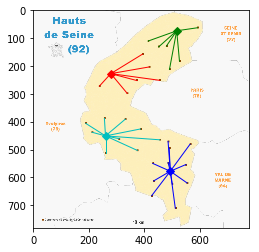

Villes ressources optimales:
Fontenay-aux-Roses
Gennevilliers
Nanterre
Ville-d'Avray
Satisfaction moyenne : 0.29843322556577967 et satifaction minimum :0.1639344262295082. 


In [112]:
#k = 4

nbvilles=len(villes)
k=4
eps=10**(-6)
(X,v_ressources)=optimisation_Q3(nbvilles, k, alpha, dist, eps)
trace_reseau(carte, X, v_ressources, coord)

print("Villes ressources optimales:")
for r in v_ressources:
    print(villes[r])

(satmoy, satmin)=satisfaction(X, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))

Optimize a model with 2666 rows, 2628 columns and 1648772 nonzeros
Variable types: 0 continuous, 2628 integer (2628 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+05]
  Objective range  [9e-07, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+05]
Presolve removed 67 rows and 322 columns
Presolve time: 3.99s
Presolved: 2599 rows, 2306 columns, 1231778 nonzeros
Variable types: 0 continuous, 2306 integer (2306 binary)
Found heuristic solution: objective 37.2701885
Found heuristic solution: objective 19.1502324

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    1388    2.7837737e-01   0.000000e+00   5.655805e-01      5s
    1857    2.0497509e-01   0.000000e+00   0.000000e+00      6s

Root relaxation: objective 2.049751e-01, 1857 iterations, 1.32 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0

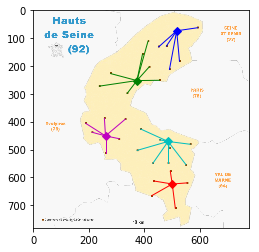

Villes ressources optimales:
Gennevilliers
Puteaux
Sceaux
Vanves
Ville-d'Avray
Satisfaction moyenne : 0.3617726861621949 et satifaction minimum :0.19455252918287938. 


In [113]:
#k = 5

nbvilles=len(villes)
k=5
eps=10**(-6)
(X,v_ressources)=optimisation_Q3(nbvilles, k, alpha, dist, eps)
trace_reseau(carte, X, v_ressources, coord)

print("Villes ressources optimales:")
for r in v_ressources:
    print(villes[r])

(satmoy, satmin)=satisfaction(X, dist, v_ressources)
print("Satisfaction moyenne : {} et satifaction minimum :{}. ".format(satmoy, satmin))